In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import copy

def cv_show(title, img):
    cv2.imshow(title, img)
    cv2.waitKey(0)                  ## Press any key to interrupt
    cv2.destroyAllWindows()


In [2]:
def CrossOp(p):
    CP_matrix = np.array([ [0, -p[2], p[1]], [p[2], 0, -p[0]], [-p[1], p[0], 0]], dtype = 'float32')
    return CP_matrix


info = np.load('TwoImageData.npy', allow_pickle=True).item()
K1 = info['K']
K2 = info['K']
F_true = (np.linalg.inv(K2)).T @ (CrossOp(info['t2']) @ info['R2']) @ np.linalg.inv(K1)
print(F_true)

[[ 6.67972386e-12 -7.85049965e-10  1.17921973e-07]
 [-9.75936932e-10 -4.86806496e-12  3.28699187e-05]
 [ 4.23506595e-07 -3.21704070e-05 -2.12002222e-04]]


<ipython-input-2-34962abd5505>:2: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  CP_matrix = np.array([ [0, -p[2], p[1]], [p[2], 0, -p[0]], [-p[1], p[0], 0]], dtype = 'float32')


# Ex 9.1

In [3]:
def normalized_2d(q):
    X = q[0, :]
    Y = q[1, :]
    T = np.array([[1/X.std(), 0, -X.mean()/X.std()], [0, 1/Y.std(), -Y.mean()/Y.std()], [0, 0, 1] ])
    q = T @ q
    return T, q

def Fest_8points(q1, q2):
    B = []
    for i, j in zip(q1, q2):
        b = np.array([ i[0]*j[0], i[0]*j[1], i[0], i[1]*j[0], i[1]*j[1], i[1], j[0], j[1], 1 ])
        B.append(b)
    B = np.array(B).reshape(-1,9)
    U, S, V = np.linalg.svd(B)
    F = V[-1,:].reshape(3,3).T
    return F
    

In [4]:
## Load data
qs = np.load('./qs.npy', allow_pickle=True)
q1 = qs.item()['q1']
q2 = qs.item()['q2']
T1, q1 = normalized_2d(q1)
T2, q2 = normalized_2d(q2)

In [5]:
F = Fest_8points(q1.T, q2.T)
F = T2.T @ F @ T1
print(F)

[[-9.20294736e-10  1.08159763e-07 -1.62466254e-05]
 [ 1.34459101e-07  6.70694594e-10 -4.52863241e-03]
 [-5.83483557e-05  4.43225764e-03  2.92084731e-02]]


In [6]:
error = np.sqrt(np.linalg.norm(F-F_true))
print(error)

0.17350770881145872


In [7]:
## Check the result
i = np.random.randint(q1.shape[0])
print(i)
print('F check: {}'.format(q2[:,i] @ F @ q1[:,i]))
print('F_true check: {}'.format(q2[:, i].T @ F_true @ q1[:, i]))

0
F check: 0.029340101483743622
F_true check: -0.0002129576135370233


# Ex 9.2

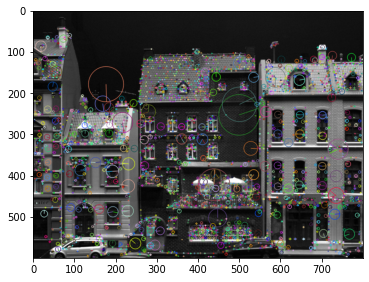

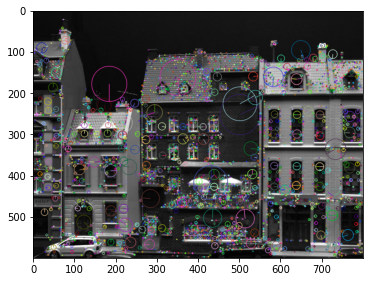

In [119]:
info = np.load('TwoImageData.npy', allow_pickle=True)
img1 = info.item()['im1']
img2 = info.item()['im2']


## Compute Sift features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp1_img = cv2.drawKeypoints(img1.copy(), kp1, img1.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_img = cv2.drawKeypoints(img2.copy(), kp2, img2.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(kp1_img)

plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.imshow(kp2_img)

In [120]:
## Match features
matcher = cv2.BFMatcher(crossCheck=True)
matches = matcher.match(des1, des2)
mathces = sorted(matches, key=lambda x:x.distance)
match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)
cv_show('match_img', match_img)

# Ex 9.3

In [161]:
class RANSNC_8Points_FundaMat():
    def __init__(self, criteria=3.84*(3**2), iterations=600):
        self.criteria = criteria
        self.iterations = iterations
        self.p = 0.99  
        self.n = 8

    def normalized_2d(self, q):
        X = q[0, :]
        Y = q[1, :]
        T = np.array([[1/X.std(), 0, -X.mean()/X.std()], [0, 1/Y.std(), -Y.mean()/Y.std()], [0, 0, 1] ])
        q = T @ q
        return T, q

    def Fest_8points(self, q1, q2):
        B = []
        for i, j in zip(q1, q2):
            b = np.array([ i[0]*j[0], i[0]*j[1], i[0], i[1]*j[0], i[1]*j[1], i[1], j[0], j[1], 1 ])
            B.append(b)
        B = np.array(B).reshape(-1,9)
        U, S, V = np.linalg.svd(B)
        F = V[-1,:].reshape(3,3).T
        F = T2.T @ F @ T1
        return F
    
    
    def Fest_InlierPoints(self, inliers):
        B = []
        P1 = np.array(inliers[:, 0, :])
        P2 = np.array(inliers[:, 1, :])
        T1, P1 = self.normalized_2d(P1.T)
        T2, P2 = self.normalized_2d(P2.T)
        for i, j in zip(P1.T, P2.T):
            b = np.array([ i[0]*j[0], i[0]*j[1], i[0], i[1]*j[0], i[1]*j[1], i[1], j[0], j[1], 1 ])
            B.append(b)
        B = np.array(B).reshape(-1,9)
        U, S, V = np.linalg.svd(B)
        F = V[-1,:].reshape(3,3).T
        return F
    
    
    def SampsonsDistance(self, F, P1, P2):
        inlier = []
        consensus = 0
        for p1, p2 in zip(P1, P2):
            Fp1 = np.dot(F, p1.reshape(-1, 1))
            Fp2 = np.dot(p2, F)
            denomenator = Fp1[0] ** 2 + Fp1[1] ** 2 + Fp2[0] ** 2 + Fp2[1] ** 2
            SampsonsDist = ((np.dot(p2, np.dot(F, p1.reshape(-1,1)))) ** 2) / denomenator
            if SampsonsDist <= self.criteria:
                inlier.append([p1, p2])
                consensus = consensus + 1
        inlier = np.array(inlier)
        return inlier, consensus
                
            
            
    def forward(self, matches, kp1, kp2):
        count = 0
        Max_Consensus = 0
        P1 = []
        P2 = []
        for m in matches:
            P1.append(kp1[m.queryIdx].pt)
            P2.append(kp2[m.trainIdx].pt)
        P1 = np.array(P1)
        P1 = np.hstack((P1, np.ones((P1.shape[0], 1))))
        P2 = np.array(P2)
        P2 = np.hstack((P2, np.ones((P2.shape[0], 1))))
        num_pairs = P2.shape[0]
        

        for i in range(self.iterations):
            match8Points = np.random.choice(matches, 8, replace=False)   #numpy.random.choice(a, size=None, replace=True, p=None)
                                                                         #从a(只要是ndarray都可以，但必须是一维的)中随机抽取数字，并组成指定大小(size)的数组
                                                                         #replace:True表示可以取相同数字，False表示不可以取相同数字
                                                                         #数组p：与数组a相对应，表示取数组a中每个元素的概率，默认为选取每个元素的概率相同。
            img1_matchPoints = []
            img2_matchPoints = []
            for m in match8Points:
                img1_matchPoints.append(kp1[m.queryIdx].pt)
                img2_matchPoints.append(kp2[m.trainIdx].pt)
            img1_matchPoints = np.array(img1_matchPoints)
            img2_matchPoints = np.array(img2_matchPoints)
            img1_matchPoints = np.hstack((img1_matchPoints, np.ones((img1_matchPoints.shape[0], 1))))
            img2_matchPoints = np.hstack((img2_matchPoints, np.ones((img2_matchPoints.shape[0], 1))))
            
            T_img1, img1_matchPoints = self.normalized_2d(img1_matchPoints.T)
            T_img2, img2_matchPoints = self.normalized_2d(img2_matchPoints.T)
            F = self.Fest_8points(img1_matchPoints.T, img2_matchPoints.T)
            F = T_img2.T @ F @ T_img1
            

            inlier, consensus = self.SampsonsDistance(F, P1, P2)
            if Max_Consensus < consensus:
                Max_Consensus = consensus
                Final_inliers = inlier
            count = count + 1
            eta = 1 - (Max_Consensus/num_pairs)
            if eta != 1:
                if (math.log((1 - math.pow((1 - eta), self.n)))) != 0:
                    N = int(math.log(1-self.p)/math.log((1 - math.pow((1 - eta), self.n))))
                    if N <= count:
                        break

        print('Set Iterations:', self.iterations)
        print('Actual Iterations:', count)
        print('Total Match Pairs:', num_pairs)
        print('Consensus:', Max_Consensus)
        Final_inliers = np.array(Final_inliers)
        F_final = self.Fest_InlierPoints(Final_inliers)
        return F_final 

In [163]:
Get_F = RANSNC_8Points_FundaMat()
F = Get_F.forward(matches, kp1, kp2)
print('Estimated Fundamental Matrix:\n', F)

Set Iterations: 600
Actual Iterations: 234
Total Match Pairs: 900
Consensus: 550
Estimated Fundamental Matrix:
 [[ 3.81097975e-04 -1.93227217e-02 -3.61901753e-02]
 [ 2.10529908e-02 -2.35981458e-03 -7.06885179e-01]
 [ 3.48800517e-02  7.04954229e-01  2.05483982e-03]]


In [167]:
info = np.load('TwoImageData.npy', allow_pickle=True)
K1 = info.item()['K']
K2 = info.item()['K'] 
R2 = info.item()['R2']
t2 = info.item()['t2']
F_true = (np.linalg.inv(K2)).T @ (CrossOp(t2) @ R2) @ np.linalg.inv(K1)
print('F_true:\n', F_true)

F_true:
 [[ 6.67972386e-12 -7.85049965e-10  1.17921973e-07]
 [-9.75936932e-10 -4.86806496e-12  3.28699187e-05]
 [ 4.23506595e-07 -3.21704070e-05 -2.12002222e-04]]


<ipython-input-44-34962abd5505>:2: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  CP_matrix = np.array([ [0, -p[2], p[1]], [p[2], 0, -p[0]], [-p[1], p[0], 0]], dtype = 'float32')


In [165]:
error = (F @ F_true).sum()/(np.linalg.norm(F) * np.linalg.norm(F_true))
print(error)

0.9361732415195804


# Ex 9.4

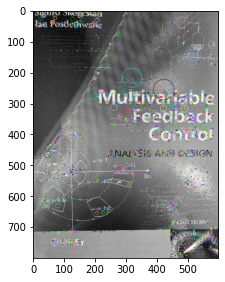

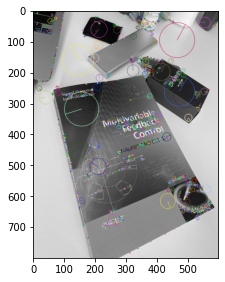

In [261]:
img1 = cv2.imread('IMG_1.png')
img1 = cv2.resize(img1, (600, 800))

img2 = cv2.imread('IMG_2.png')
img2 = cv2.resize(img2, (600, 800))

gray1 = cv2.cvtColor(img1.copy(), cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2.copy(), cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1.copy(), None)
kp2, des2 = sift.detectAndCompute(gray2.copy(), None)

kp1_img = cv2.drawKeypoints(gray1.copy(), kp1, img1.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_img = cv2.drawKeypoints(gray2.copy(), kp2, img2.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(kp1_img)

plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.imshow(kp2_img)

In [210]:
matcher = cv2.BFMatcher(crossCheck=True)
matches = matcher.match(des1, des2)
matches_sort = sorted(matches, key=lambda x:x.distance)
match_img = cv2.drawMatches(img1.copy(), kp1, img2.copy(), kp2, matches[:50], None, flags=2)
cv_show('match_img', match_img)

In [262]:
def BF_matcher_RatioTest(des1, des2, Ratio):
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(des1, des2, k=2)
    good = []
    for i, j in matches:
        if i.distance / j.distance < Ratio:
            good.append(i)
    good = sorted(good, key=lambda x:x.distance)
    return good

matches = BF_matcher_RatioTest(des1, des2, 0.7)
match_img = cv2.drawMatches(img1.copy(), kp1, img2.copy(), kp2, matches[:50], None, flags=2)
cv_show('match', match_img)

In [277]:
Get_F = RANSNC_8Points_FundaMat(iterations=3000)
F = Get_F.forward(matches, kp1, kp2)
print(F)

Set Iterations: 3000
Actual Iterations: 3000
Total Match Pairs: 213
Consensus: 2
[[-3.26902401e-01  1.22588400e-01 -4.16333634e-17]
 [ 3.05332398e-01 -1.22588400e-01  4.16333634e-17]
 [-4.16333634e-17  4.16333634e-17  8.77411600e-01]]


In [275]:
p1 = np.array(kp1[matches[2].queryIdx].pt)
p2 = np.array(kp2[matches[2].trainIdx].pt)

In [272]:
p1 = np.hstack((p1, 1))
p2 = np.hstack((p2, 1))

In [273]:
p2 @ F @ p1

1593.3807547669637